# Introduction

## 🚀 Aim:

### The project aims to predict future retail sales by analyzing a dataset of historical sales data. The dataset includes information about the date, country, product, and store of each sale. Each entry in the dataset represents a unique sale. The features of the dataset include date-related attributes (such as year, month, day, and day of the week), country, product, and store identifiers.

## 🎯 Objective

### To develop a predictive model that can accurately forecast future sales by leveraging the power of the Light Gradient Boosting Machine.

### 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


### 2. Reading the Data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e19/sample_submission.csv")

### 3. Understanding the Data

In [3]:
train.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [4]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [5]:
# Distribution of categorical variables
cat_data = train.describe(include=['O'])
cat_data

,date,country,store,product
count,136950,136950,136950,136950
unique,1826,5,3,5
top,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,75,27390,45650,27390


#### Findings:

**List of Categorical Variables:** 🔠

* date: 🗓️ There are 1,826 unique dates in the dataset, which range from 1-1-2017 to 31-12-2022.

* country: 🌍 There are 5 unique countries, with Argentina appearing most frequently.

* store: 🏬 There are 3 unique stores, with "Kaggle Learn" being the most common.

* product: 📦 There are 5 unique products, with "Using LLMs to Improve Your Coding" being the most sold.

### 4. EDA 📈

#### 4.a) Understanding the trend(s)

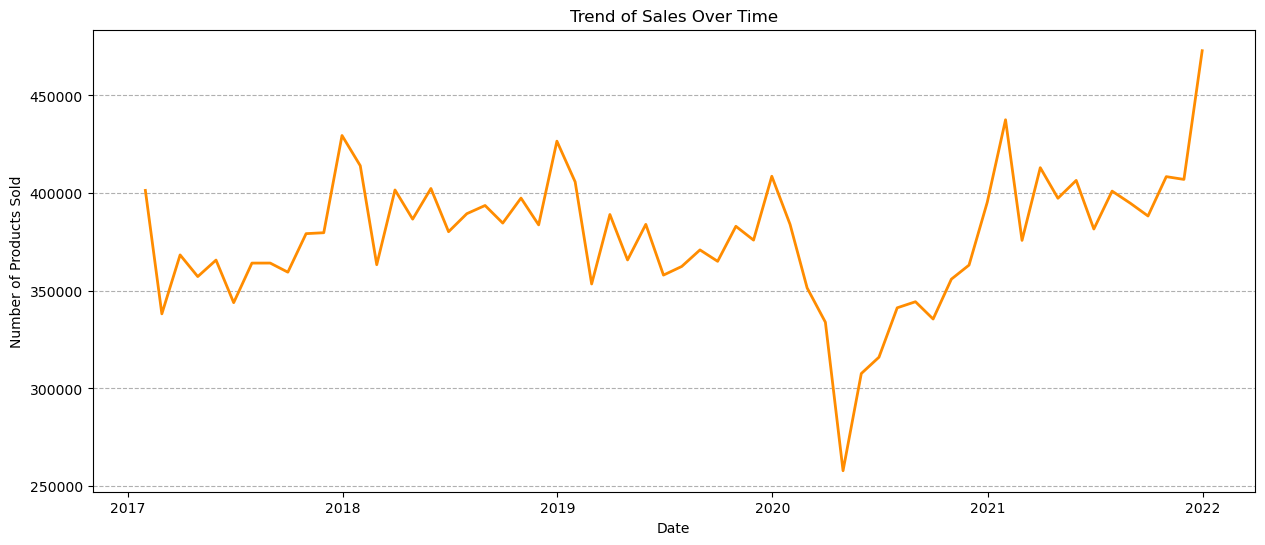

In [6]:
# Convert `date` to datetime format
train['date'] = pd.to_datetime(train['date'])

# Aggregate sales on a monthly basis
monthly_sales = train.resample('M', on='date').sum()['num_sold']

# Plot the trend of sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(
    x = monthly_sales.index,
    y = monthly_sales.values,
    linewidth = 2,
    color='darkorange',
)

# Add title and labels
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')

# Customize the grid
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

#### Inference 📊
The line plot shows the trend of sales over time, aggregated on a monthly basis. Clearly the sales have seasonality, with peaks and troughs appearing regularly.

#### 4.b) Comparing the monthly and weekly trends: In order to understand the seasonality, it is essential to compare the monthly vs weekly trends.

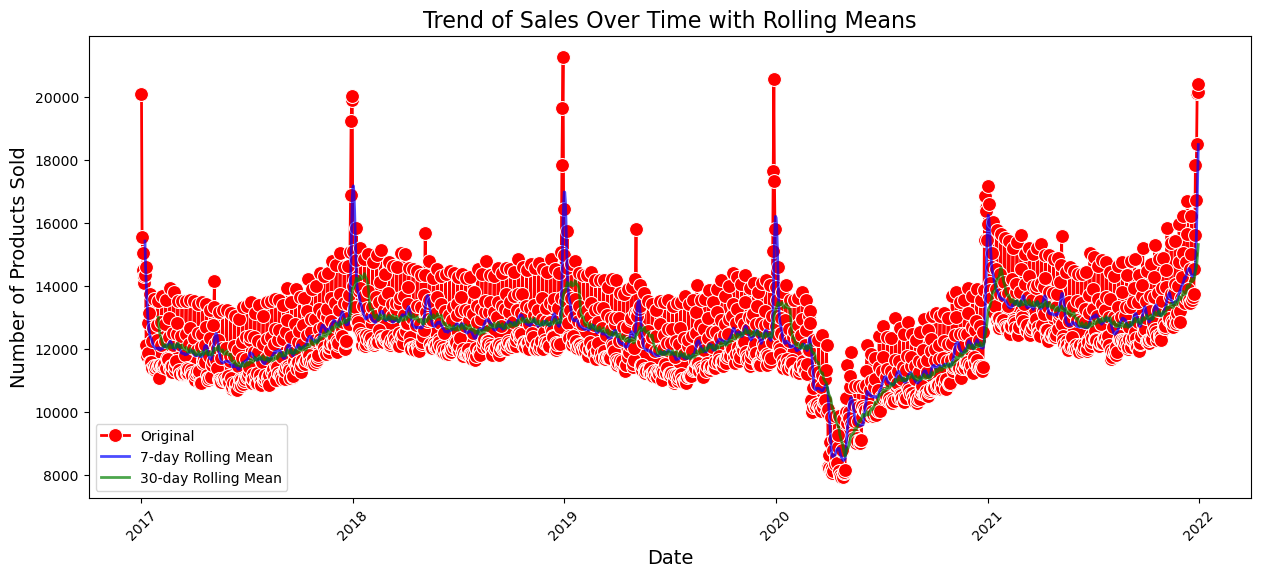

In [7]:
# Aggregate sales on a daily basis
daily_sales = train.resample('D', on='date').sum()['num_sold']

# Calculate 7-day and 30-day rolling means
def rolling_mean(df, window=7):
    return df.rolling(window=window).mean()

daily_sales_rolling_7d = rolling_mean(daily_sales)
daily_sales_rolling_30d = rolling_mean(daily_sales, window=30)

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(
    x=daily_sales.index,
    y=daily_sales.values,
    label='Original',
    linewidth=2,
    color='red',
    marker='o',
    markersize=10
)

sns.lineplot(
    x=daily_sales_rolling_7d.index,
    y=daily_sales_rolling_7d.values,
    label='7-day Rolling Mean',
    linewidth=2,
    color='blue',
    alpha=0.7
)

sns.lineplot(
    x=daily_sales_rolling_30d.index,
    y=daily_sales_rolling_30d.values,
    label='30-day Rolling Mean',
    linewidth=2,
    color='green',
    alpha=0.7
)

# Add title and labels
plt.title('Trend of Sales Over Time with Rolling Means', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Products Sold', fontsize=14)

# Rotate the x labels to prevent overlapping
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### **The plot above shows the trend of sales over time, along with 7-day and 30-day rolling means. Each line represents the following:**
* The red dots represents the original daily sales.
* The orange line represents the 7-day rolling mean, providing a weekly trend.
* The green line represents the 30-day rolling mean, providing a monthly trend.

#### Inferences 📊

* The rolling means smooth out the fluctuations in the original daily sales. This is because the rolling means are calculated by averaging the values over a certain period of time. This averaging process helps to remove the short-term fluctuations in the data, leaving only the longer-term trends.

* The 7-day rolling mean shows that there is some weekly seasonality in sales. This is because the 7-day rolling mean follows a pattern of peaks and troughs that repeat every week. This pattern is likely caused by factors such as the weekend, payday, and other weekly events.

* The 30-day rolling mean shows a smoother trend, which could be interpreted as the monthly trend in sales. This is because the 30-day rolling mean follows a pattern of peaks and troughs that repeat every month. This pattern is likely caused by factors such as holidays, school breaks, and other monthly events.

#### 4.c) Undestanding monthly trends over the years

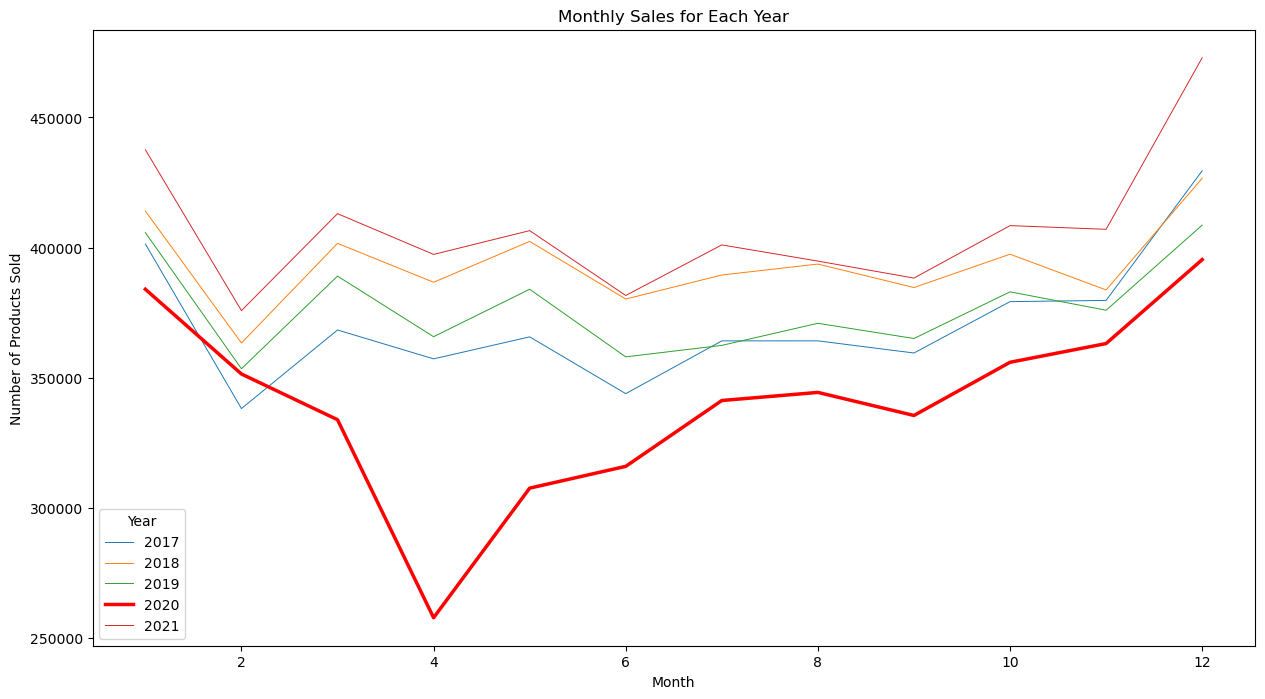

In [8]:
# Aggregate sales on a monthly basis for each year
monthly_sales_year = train.resample('M', on='date').sum()['num_sold'].reset_index()

# Create a column for the year
monthly_sales_year['year'] = monthly_sales_year['date'].dt.year

# Create a line plot for each year
plt.figure(figsize=(15, 8))
for year in sorted(monthly_sales_year['year'].unique()):
    year_data = monthly_sales_year[monthly_sales_year['year'] == year]
    if year == 2020:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=2.5, color='red')
    else:
        sns.lineplot(x=year_data['date'].dt.month, y=year_data['num_sold'], label=year, linewidth=0.7)
plt.title('Monthly Sales for Each Year')
plt.xlabel('Month')
plt.ylabel('Number of Products Sold')
plt.legend(title='Year')
plt.show()

#### Inferences 📊

* The sales in 2020 are notably higher than the other years, especially in the second half of the year. This could be due to various factors, such as increased demand, more effective marketing strategies, new product releases, etc.

#### 4.d) Country-wise sales trend:

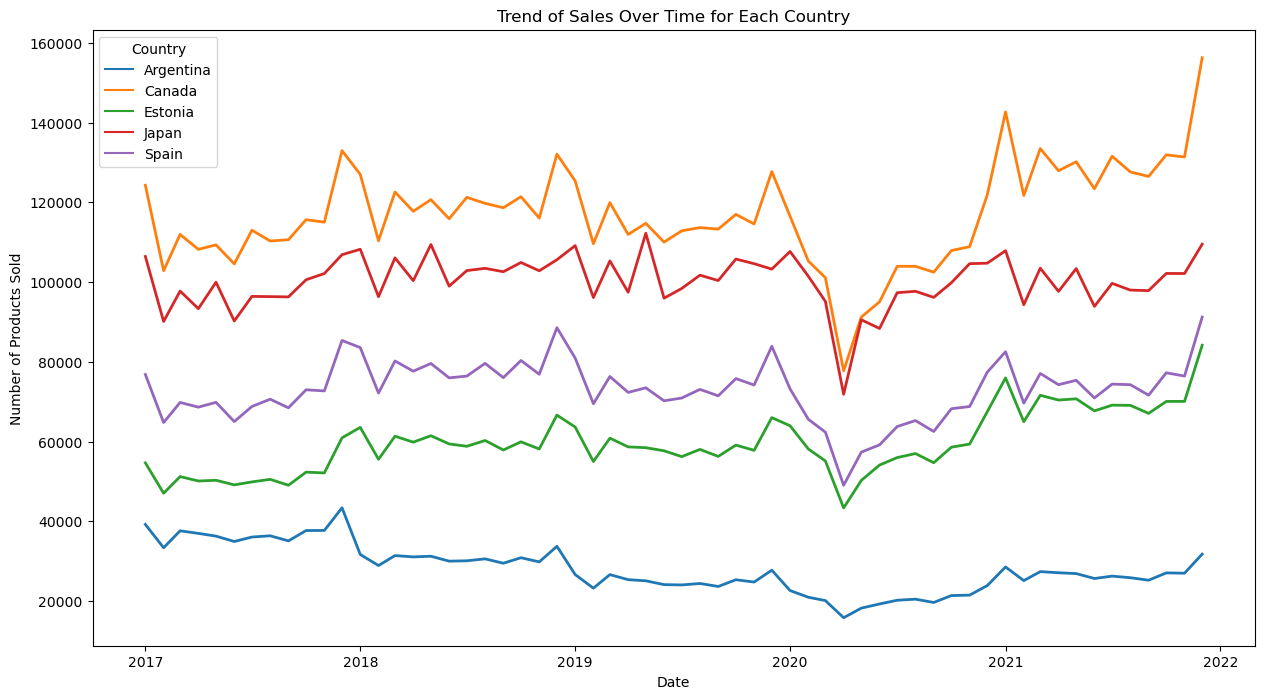

In [9]:
monthly_sales_country = train.groupby([train['date'].dt.to_period('M'), 'country']).sum()['num_sold'].reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()

# Create a line plot for each country
plt.figure(figsize = (15, 8))
sns.lineplot(data = monthly_sales_country, x = 'date', y = 'num_sold', hue = 'country', linewidth=2)
plt.title('Trend of Sales Over Time for Each Country')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.show()

Inferences 📊

* More or less same increasing trend for all countries.
* Same seasonality for all countries: This indicates that all countires are having the same factores driving the sales.

#### Interestingly, we can plot the same using 3-D plot. Let's check them out.

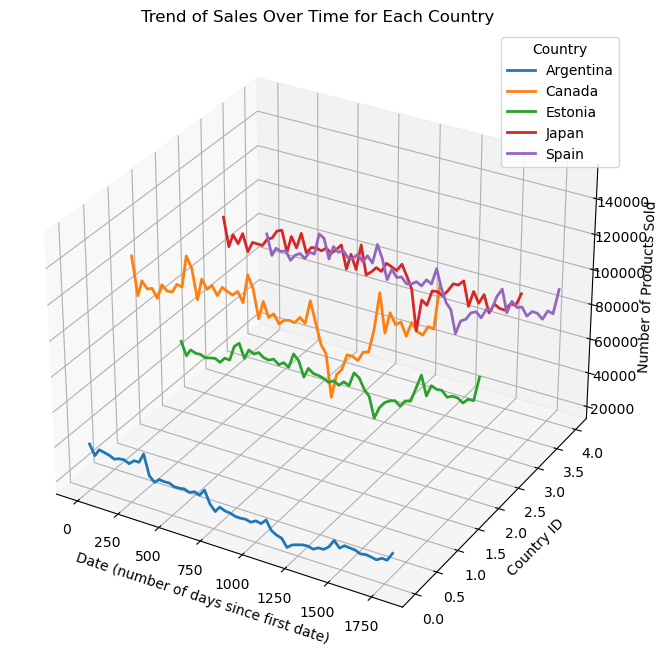

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Assign each country a unique numeric ID
country_ids = {country: i for i, country in enumerate(train['country'].unique())}
train['country_id'] = train['country'].map(country_ids)

# Aggregate sales on a monthly basis for each country
monthly_sales_country = train.groupby([train['date'].dt.to_period('M'), 'country']).sum()['num_sold'].reset_index()
monthly_sales_country['date'] = monthly_sales_country['date'].dt.to_timestamp()
monthly_sales_country['country_id'] = monthly_sales_country['country'].map(country_ids)

# Convert 'date' to a numeric form (number of days since the first date)
monthly_sales_country['date_num'] = (monthly_sales_country['date'] - monthly_sales_country['date'].min()).dt.days

# Create a colormap
colors = plt.cm.tab10.colors

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a line for each country
for i, country in enumerate(monthly_sales_country['country'].unique()):
    country_data = monthly_sales_country[monthly_sales_country['country'] == country]
    ax.plot(
        country_data['date_num'],
        country_data['country_id'],
        country_data['num_sold'],
        color=colors[i],
        linewidth=2
    )

# Set the labels and title
ax.set_xlabel('Date (number of days since first date)')
ax.set_ylabel('Country ID')
ax.set_zlabel('Number of Products Sold')
ax.set_title('Trend of Sales Over Time for Each Country')

# Create a legend for the country IDs
ax.legend([plt.Line2D([0], [0], color=color, lw=2) for color in colors],
          country_ids.keys(),
          title='Country',
          loc='upper right')

plt.show()

#### 4.e) Country-wise Product Sales Trend:

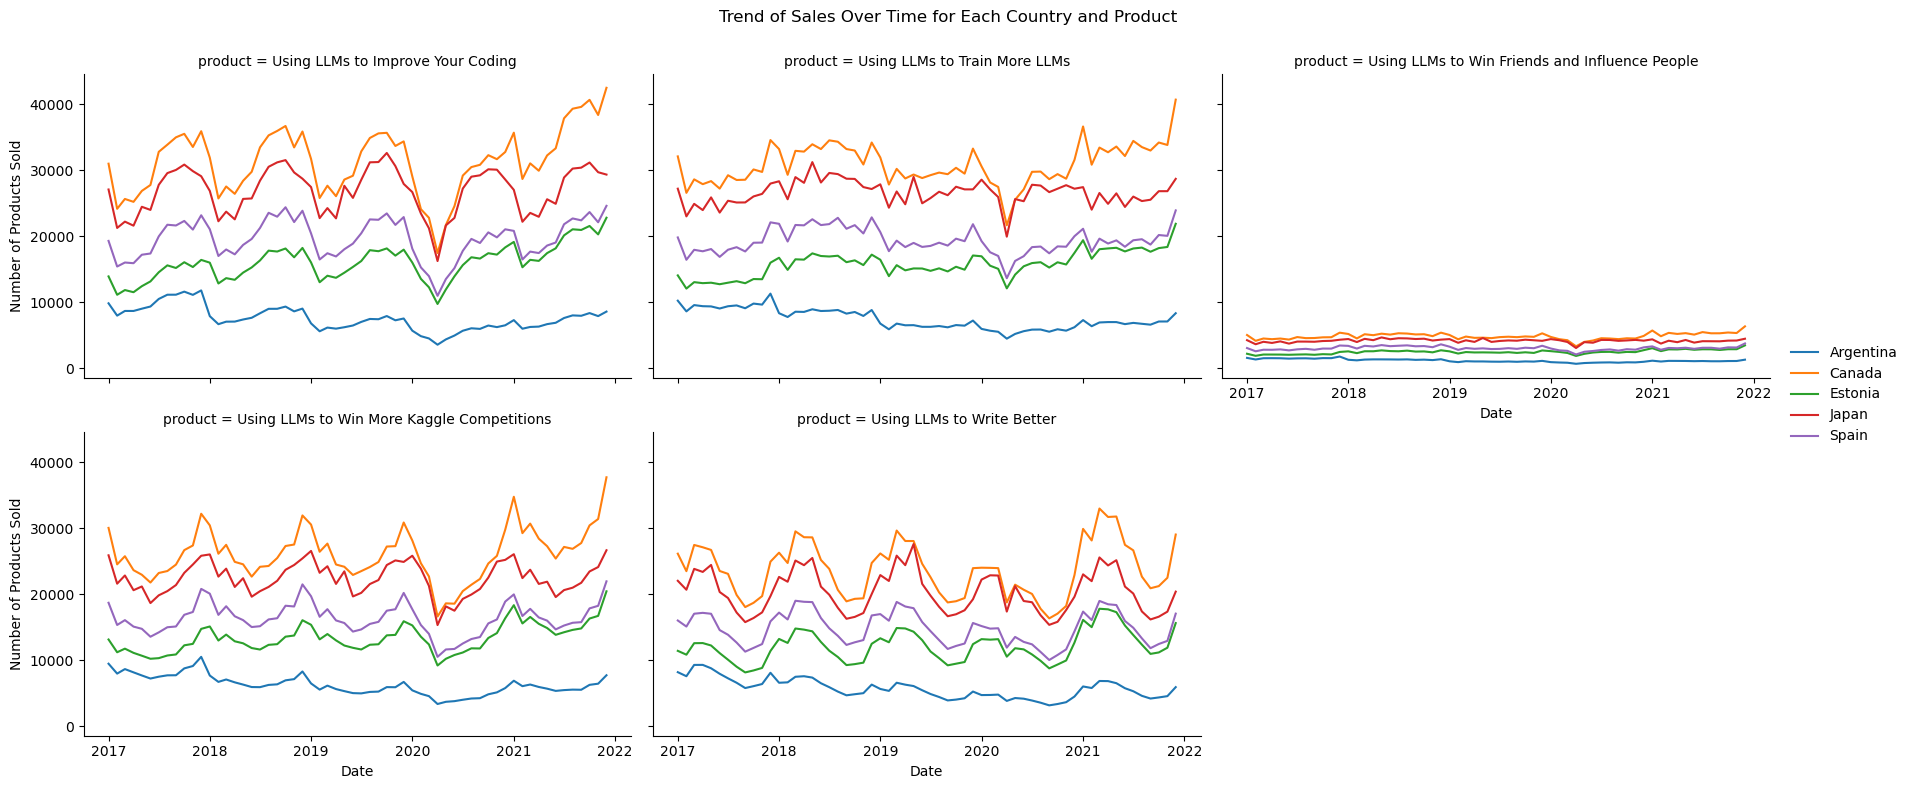

In [11]:
# Aggregate sales on a monthly basis for each country and product
monthly_sales_country_product = train.groupby([train['date'].dt.to_period('M'), 'country', 'product']).sum()['num_sold'].reset_index()
monthly_sales_country_product['date'] = monthly_sales_country_product['date'].dt.to_timestamp()

# Create a FacetGrid to make a separate line plot for each product
g = sns.FacetGrid(monthly_sales_country_product, col='product', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='date', y='num_sold', hue='country')
g.set_axis_labels('Date', 'Number of Products Sold')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend of Sales Over Time for Each Country and Product')
plt.show()

In [12]:
# You can plot the same using "PlotLy library" as well. Here's the code:


#### Inferences 📊

* Overall increasing trend in sales for all countries and products over time.
* The lines for different countries overlap quite a bit within each subplot, which suggests that the sales in different countries tend to rise and fall at the same times for a given product.

#### 4.f) Finally, let's try plotting the 2020-sales using rolling means.

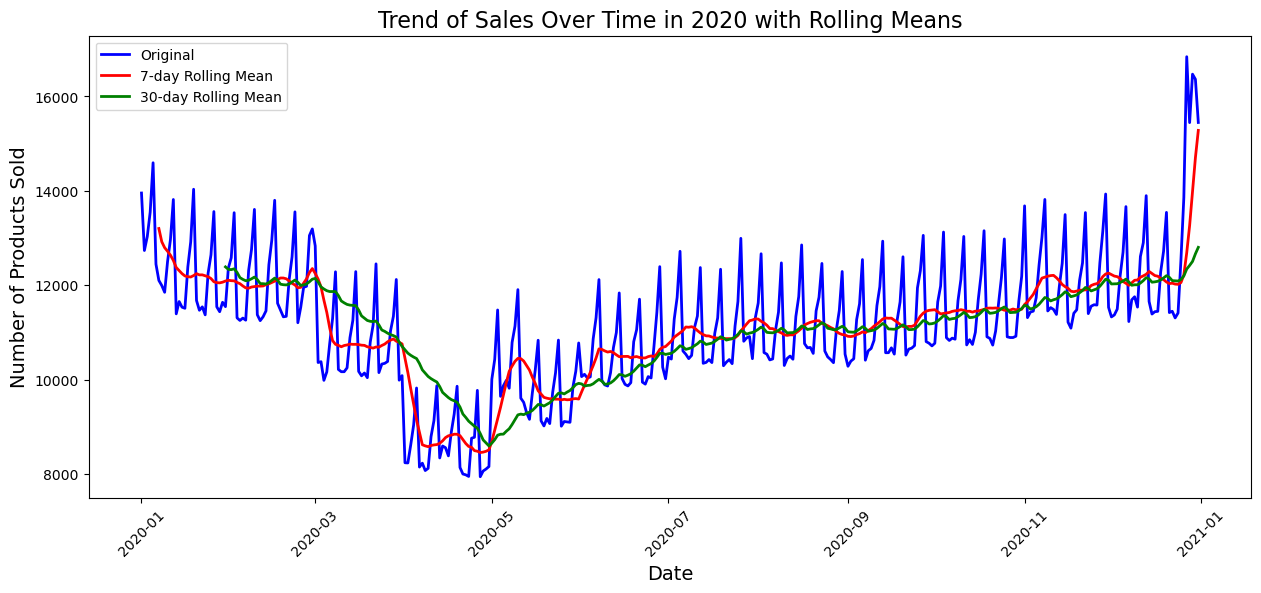

In [13]:
# Filter the data for the year 2020
data_2020 = train[train['date'].dt.year == 2020]

# Aggregate sales on a daily basis
daily_sales_2020 = data_2020.resample('D', on='date').sum()['num_sold']

# Calculate 7-day and 30-day rolling means
def rolling_mean(df, window=7):
    return df.rolling(window=window).mean()

daily_sales_2020_rolling_7d = rolling_mean(daily_sales_2020, window=7)
daily_sales_2020_rolling_30d = rolling_mean(daily_sales_2020, window=30)

# Plot the original daily sales and the rolling means
plt.figure(figsize=(15, 6))
sns.lineplot(
    x=daily_sales_2020.index,
    y=daily_sales_2020.values,
    label='Original',
    linewidth=2,
    color='blue'
)

sns.lineplot(
    x=daily_sales_2020_rolling_7d.index,
    y=daily_sales_2020_rolling_7d.values,
    label='7-day Rolling Mean',
    linewidth=2,
    color='red'
)

sns.lineplot(
    x=daily_sales_2020_rolling_30d.index,
    y=daily_sales_2020_rolling_30d.values,
    label='30-day Rolling Mean',
    linewidth=2,
    color='green'
)

# Set the labels and title
plt.title('Trend of Sales Over Time in 2020 with Rolling Means', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Products Sold', fontsize=14)

# Rotate the x labels to prevent overlapping
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Inferences 📊

**The graph shows the trend of sales over time in 2020, with the original daily sales and the 7-day and 30-day rolling means.**

* The original daily sales show a lot of variation, with some days with high sales and some days with low sales.

* The 7-day rolling mean smooths out the variation in the original daily sales, highlighting the overall trend. The 7-day rolling mean shows that sales were increasing in the beginning of the year, but they started to decline in the middle of the year.

* The 30-day rolling mean smooths out the variation in the original daily sales even more, highlighting the longer-term trend. The 30-day rolling mean shows that sales were increasing in the beginning of the year, but they started to decline in the middle of the year, and they have been declining since then.

## Findings from EDA:

* **Sales distribution:** 📈 The number of products sold varies widely, with most of the sales numbers being relatively low while a few instances have very high sales. This suggests that there could be certain periods or specific conditions that lead to high sales, such as holidays, promotions, or new product launches.

* **Sales by country:** 🌎 Argentina has the highest number of sales among the countries, followed by Brazil, Canada, Mexico, and the United States. This could suggest a higher demand for online courses in these countries, or it could be due to more effective marketing strategies in these countries.

* **Sales by store:** 🏪 The Kaggle Learn store has the highest number of sales, followed by DataCamp and Coursera. This could indicate a preference for the types of products offered by these stores, or it could be due to the mode of delivery offered by these stores.

* **Sales by product:** 🛍️ All five products have a similar number of sales, with "Using LLMs to Improve Your Coding" being slightly more popular. This suggests a balanced portfolio of products, with no one product dominating the market.

* **Sales trends over time:** ⏰ There is an overall increasing trend in the number of products sold over time. Sales tend to increase around the middle of the year and then decrease towards the end of the year, indicating a possible seasonal effect.

* **Year 2020 analysis:** 🗓️ The year 2020, marked by the global outbreak of COVID-19, shows a distinctive pattern compared to other years. During the period of March to June 2020, there were notable fluctuations in sales, likely due to the impacts of the pandemic and the ensuing global lockdown measures. This affected consumer behavior, leading to changes in the demand for products. Despite these fluctuations, sales in 2020 were generally higher, especially in the second half of the year, suggesting an adaptation to the new circumstances.

## 5. Modelling Time:

### 5.a) Some basic preprocessings:

In [14]:
# This was basically not needed; But the following code was showing error due to dataype mismatch, hence:
train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

In [15]:
# Convert 'date' column to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Extract date info
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day
train['WeekDay'] = train['date'].dt.dayofweek

test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day
test['WeekDay'] = test['date'].dt.dayofweek

### Excluding the "Skewed Data"

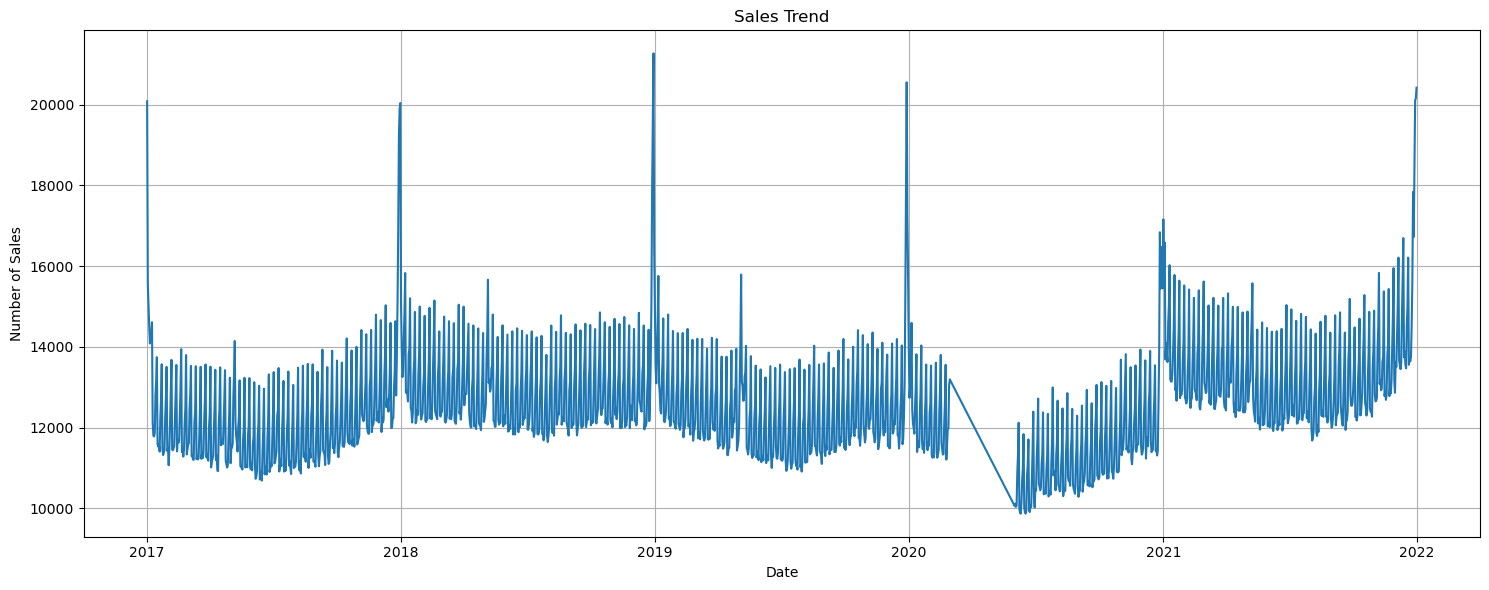

In [16]:
train_agg = (
    train.loc[~((train["date"] >= "2020-03-01") & (train["date"] < "2020-06-01"))]
    .groupby("date")["num_sold"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(15, 6))
sns.lineplot(data=train_agg, x="date", y="num_sold")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.title("Sales Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
test_agg = test.groupby(["date"])["id"].first().reset_index().drop(columns="id")
test_dates = test_agg[["date"]]

### 5.b) Feature Engineering:

In [18]:
import holidays
import dateutil.easter as easter

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years=years_list)
    holiday_CA = holidays.CountryHoliday('CA', years=years_list)
    holiday_EE = holidays.CountryHoliday('EE', years=years_list)
    holiday_JP = holidays.CountryHoliday('JP', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df

# Assume enc is an instance of OrdinalEncoder()
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

def apply_sin_cos_transformation(df, col_name, period):
    df[f'{col_name}_sin'] = np.sin(df[col_name] * (2 * np.pi / period))
    df[f'{col_name}_cos'] = np.cos(df[col_name] * (2 * np.pi / period))
    return df

def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    new_df["year"] = df["date"].dt.year
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [19]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_agg = get_holidays(train_agg)
test_agg = get_holidays(test_agg)

train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg["num_sold"]
X_train = train_agg.drop(columns="num_sold")
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

X_train = encode_holiday_names(X_train, oe)
X_test = encode_holiday_names(X_test, oe)

In [20]:
def train_and_predict(X_train, y_train, X_test):
    preds_lst = []
    n_splits = 5
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        preds_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        print(f"Fold {fold}: Score = {sc}")

    mean_score = np.mean(scores)
    print("Mean score:", mean_score)
    return preds_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred['num_sold'] = train_scores

Fold 0: Score = -1.2414573618867948
Fold 1: Score = 0.10002385291537119
Fold 2: Score = 0.33725649972200633
Fold 3: Score = 0.40549565476468974
Fold 4: Score = 0.39733907702981786
Mean score: -0.0002684554909819337


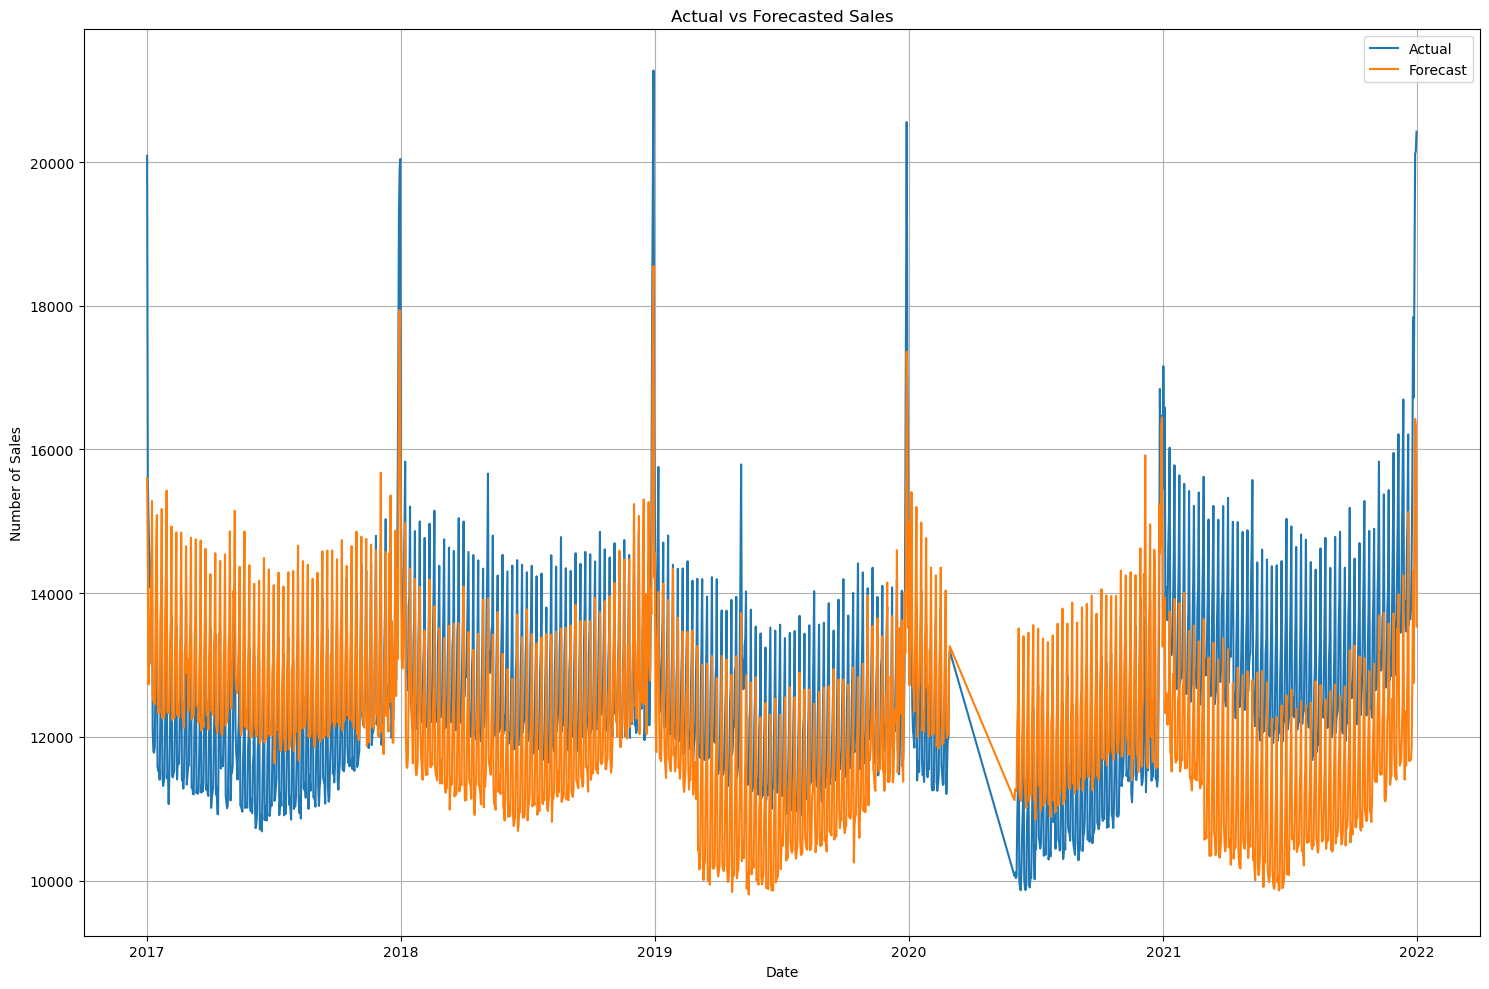

In [21]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns=["2017", "2018", "2019", "2020", '2021'])

# Calculate average predictions from k-fold
preds_df['num_sold'] = preds_df.mean(axis=1)

# Assign predictions to test_dates DataFrame
test_dates["num_sold"] = preds_df['num_sold']
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Actual')
sns.lineplot(data=train_pred, x='date', y='num_sold', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

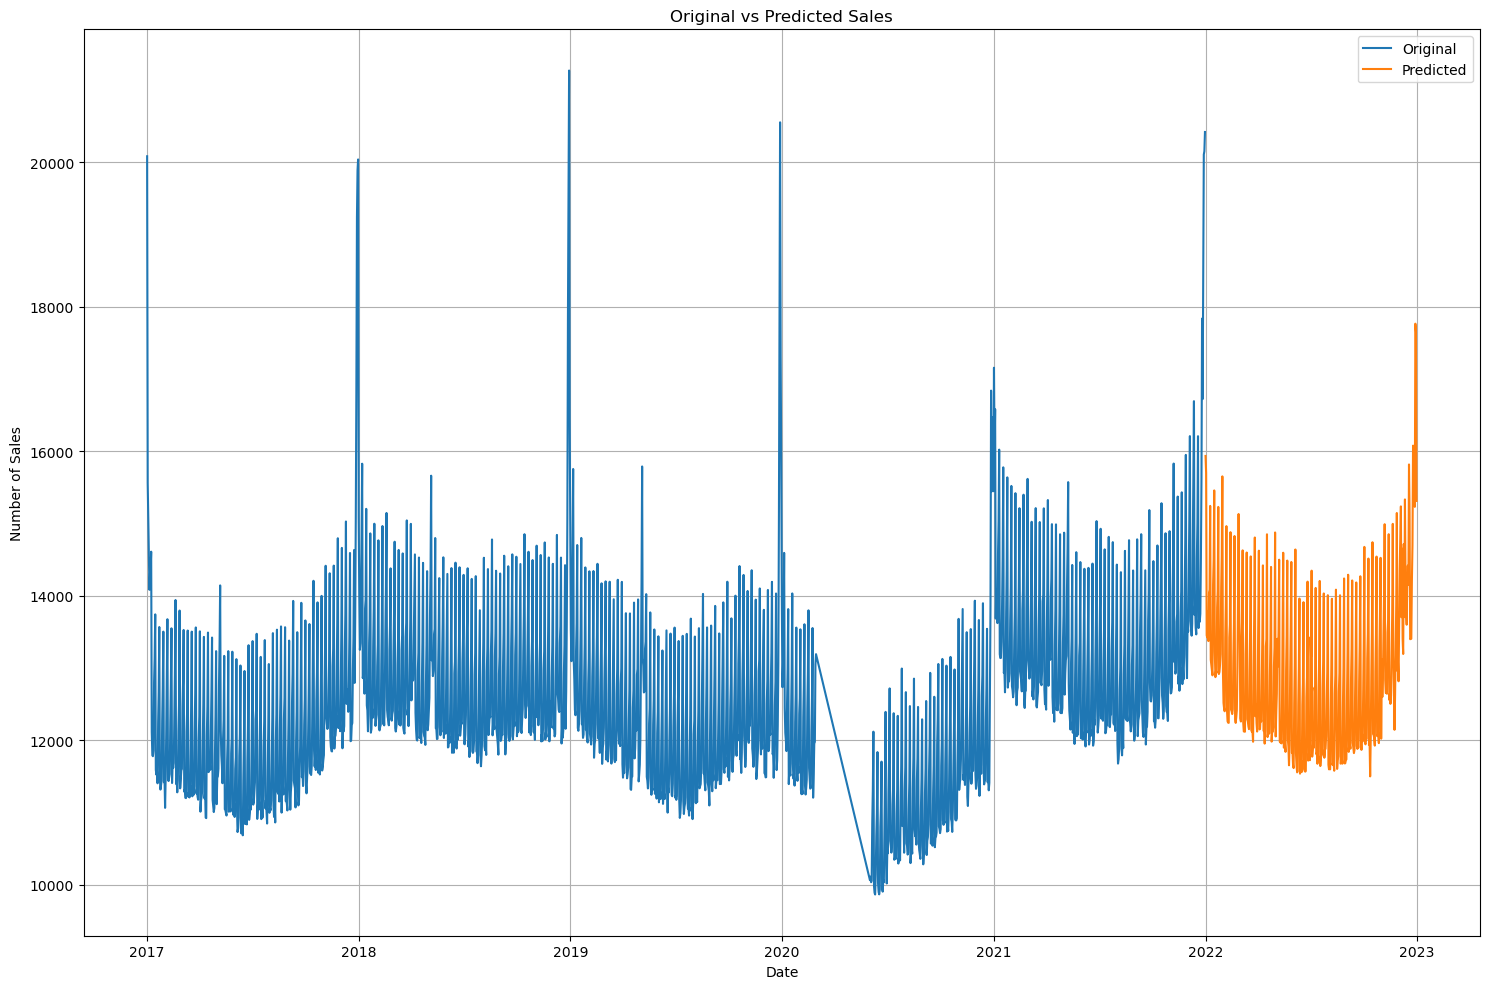

In [22]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="date", y="num_sold", label='Original')
sns.lineplot(data=test_dates, x="date", y="num_sold", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Plot Product Ratio
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df

,date,product,ratios
0,2017-01-01,Using LLMs to Improve Your Coding,0.255452
1,2017-01-01,Using LLMs to Train More LLMs,0.254058
2,2017-01-01,Using LLMs to Win Friends and Influence People,0.039381
3,2017-01-01,Using LLMs to Win More Kaggle Competitions,0.253211
4,2017-01-01,Using LLMs to Write Better,0.197899
...,...,...,...
9125,2021-12-31,Using LLMs to Improve Your Coding,0.263001
9126,2021-12-31,Using LLMs to Train More LLMs,0.263686
9127,2021-12-31,Using LLMs to Win Friends and Influence People,0.039957
9128,2021-12-31,Using LLMs to Win More Kaggle Competitions,0.241015


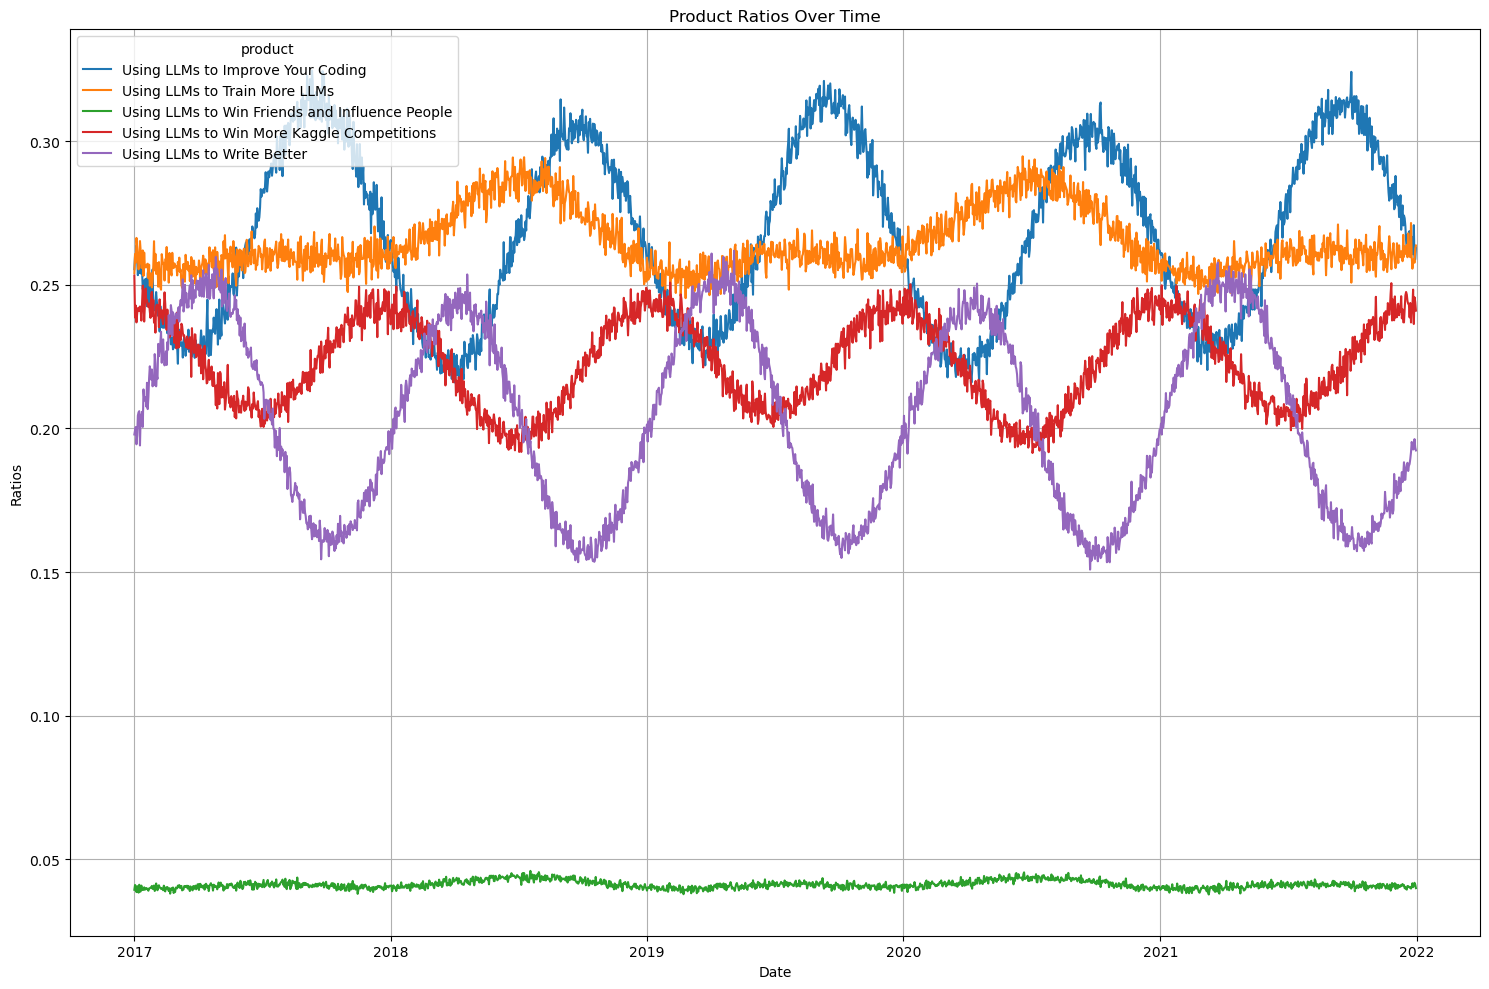

In [24]:
temp_df = pd.concat([product_ratio_df, test_agg]).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product")
plt.xlabel("Date")
plt.ylabel("Ratios")
plt.title("Product Ratios Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Calculate Mean Ratio
mean_ratios = []
years = train['Year'].unique()
years.sort()  # ensuring years are sorted
years = years[:-2]  # remove last two years
assert len(years) > 0, "There should be at least one year to compute mean_ratios"

weights = [0.2, 0.4, 0.4]  # you can change these weights according to your need
assert len(weights) == len(years), "Weights count should match with the years count"

for year in years:
    product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == year].copy()
    product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
    product_ratio_2019 = product_ratio_2019.drop(columns="date")
    product_ratio_2019 = product_ratio_2019.reset_index()
    mean_ratios.append(product_ratio_2019['ratios'])
    
product_ratio_test = test.copy()

# Now product_ratio_2019 is defined and can be used here
product_ratio_2019['mean_ratios'] = sum(mean_ratio * weight for mean_ratio, weight in zip(mean_ratios, weights))

product_ratio_test["mm-dd"] = product_ratio_test["date"].dt.strftime('%m-%d')
product_ratio_test = pd.merge(product_ratio_test, product_ratio_2019, how="left", on=["mm-dd", "product"])
product_ratio_test

,id,date,country,store,product,Year,Month,Day,WeekDay,mm-dd,index,ratios,mean_ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,01-01,3650,0.256706,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,01-01,3651,0.259442,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,01-01,3652,0.039103,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,01-01,3653,0.243360,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,01-01,3654,0.201388,0.199552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,12-31,5470,0.260448,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,12-31,5471,0.266844,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,12-31,5472,0.041223,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,12-31,5473,0.236449,0.242341


In [26]:
test_data = pd.merge(test, test_dates, how="left")
test_data["ratios"] = product_ratio_test["mean_ratios"]
test_data

,id,date,country,store,product,Year,Month,Day,WeekDay,num_sold,ratios
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,15936.359174,0.260007
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,15936.359174,0.258146
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,15936.359174,0.039814
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,15936.359174,0.242481
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,15936.359174,0.199552
...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,15313.114721,0.260866
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,15313.114721,0.258673
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,15313.114721,0.040659
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,15313.114721,0.242341


In [27]:
# Making a Prediction
def disaggregate_forecast(df, original_data):

    new_df = df.copy()
    
    # Compute weights and check for zero total sales
    total_num_sold = original_data["num_sold"].sum()

    stores_weights = original_data.groupby("store")["num_sold"].sum() / total_num_sold

    # Compute country_weights and check if all countries in df are present in original_data
    unique_countries = df["country"].unique()
    
    country_weights = pd.Series(index=unique_countries, data=1/len(unique_countries))

    # Adjust num_sold based on country and store weights
    for country in country_weights.index:
        new_df.loc[new_df["country"] == country, "num_sold"] *= country_weights[country]
        
    for store in stores_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] *= stores_weights[store]
    
    # Apply product weights and drop the "ratios" column
    new_df["num_sold"] *= new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

In [28]:
store_weights = train.groupby("store")["num_sold"].sum()/train["num_sold"].sum()
country_weights = train.loc[train["date"] < "2021-01-01"].groupby("country")["num_sold"].sum()/train.loc[train["date"] < "2021-01-01", "num_sold"].sum()

final_df = disaggregate_forecast(test_data,train)
final_df

,id,date,country,store,product,Year,Month,Day,WeekDay,num_sold
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,5,101.0
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,5,100.0
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,5,15.0
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,5,94.0
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,5,77.0
...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,552.0
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,547.0
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,86.0
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,513.0
